In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import pickle

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import numpy as np
import csv
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

/kaggle/input/CATelcoCustomerChurnTrainingSample.csv


In [2]:
df = pd.read_csv("/kaggle/input/CATelcoCustomerChurnTrainingSample.csv", sep=",")
df.head(n=10)

,age,annualincome,calldroprate,callfailurerate,callingnum,customerid,customersuspended,education,gender,homeowner,...,totalminsusedinlastmonth,unpaidbalance,usesinternetservice,usesvoiceservice,percentagecalloutsidenetwork,totalcallduration,avgcallduration,churn,year,month
0,12,168147,0.06,0.00,4251078442,1,Yes,Bachelor or equivalent,Male,Yes,...,15,19,No,No,0.82,5971,663,0,2015,1
1,12,168147,0.06,0.00,4251078442,1,Yes,Bachelor or equivalent,Male,Yes,...,15,19,No,No,0.82,3981,995,0,2015,2
2,42,29047,0.05,0.01,4251043419,2,Yes,Bachelor or equivalent,Female,Yes,...,212,34,No,Yes,0.27,7379,737,0,2015,1
3,42,29047,0.05,0.01,4251043419,2,Yes,Bachelor or equivalent,Female,Yes,...,212,34,No,Yes,0.27,1729,432,0,2015,2
4,58,27076,0.07,0.02,4251055773,3,Yes,Master or equivalent,Female,Yes,...,216,144,No,No,0.48,3122,624,0,2015,1
5,58,27076,0.07,0.02,4251055773,3,Yes,Master or equivalent,Female,Yes,...,216,144,No,No,0.48,2769,553,0,2015,2
6,20,137977,0.05,0.03,4251042488,4,Yes,PhD or equivalent,Male,No,...,412,159,Yes,No,0.94,834,834,0,2015,1
7,20,137977,0.05,0.03,4251042488,4,Yes,PhD or equivalent,Male,No,...,412,159,Yes,No,0.94,5868,838,0,2015,2
8,36,136006,0.07,0.00,4251073177,5,Yes,High School or below,Male,Yes,...,416,19,No,No,0.15,1886,628,0,2015,1
9,36,136006,0.07,0.00,4251073177,5,Yes,High School or below,Male,Yes,...,416,19,No,No,0.15,2602,867,0,2015,2


In [3]:
print("Tamanho do DATAFRAME")
print("Linhas: ",df.shape[0])
print("Colunas: ",df.shape[1])

Tamanho do DATAFRAME
Linhas:  20468
Colunas:  29


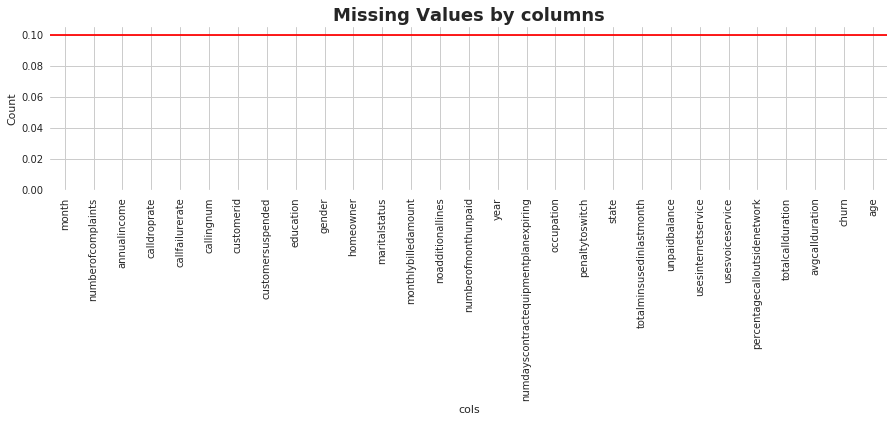

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
#df.isnull().sum() / df.shape[0]
plt.style.use('seaborn')
sns.set_style('whitegrid')

plt.subplots(0,0,figsize=(15,3))

df.isnull().mean().sort_values(ascending=False).plot.bar(color='black')
plt.axhline(y=0.1, color='r', linestyle='-')
plt.title('Missing Values by columns', fontsize=18, weight='bold' )
plt.xlabel("cols")
plt.ylabel("Count")
plt.show()

/opt/conda/lib/python3.6/site-packages/matplotlib/legend.py:497: UserWarning: Unrecognized location "up right". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


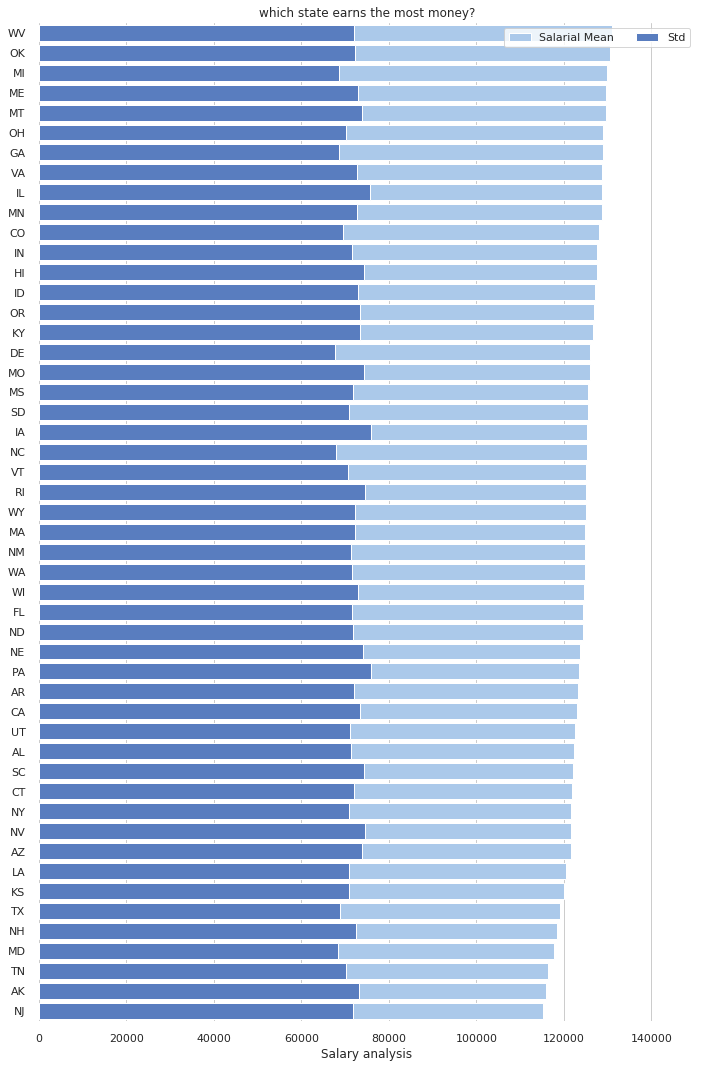

In [5]:
estados = df.groupby('state', as_index=False).agg({'annualincome':['mean', 'std']})
estados.columns = ["_".join(x) for x in estados.columns.ravel()]
estados = estados.sort_values('annualincome_mean', ascending=False)

sns.set(style="whitegrid")

f, ax = plt.subplots(figsize=(10, 15))
sns.set_color_codes("pastel")
sns.barplot(y = 'state_', x ='annualincome_mean',data=estados,
           label = 'Salarial Mean', color='b')

sns.set_color_codes("muted")
sns.barplot(y='state_', x='annualincome_std', data=estados,
            label='Std', color = 'b')

ax.legend(ncol=2, frameon=True, loc="up right")

ax.set(xlim=(0, 150000), ylabel="",
      xlabel="Salary analysis")

sns.despine(left = True, bottom = True)

plt.title("which state earns the most money?");
plt.tight_layout();

# What factors influence customers to buy again?

* Are the customers who use our delivery service the most likely to buy again?

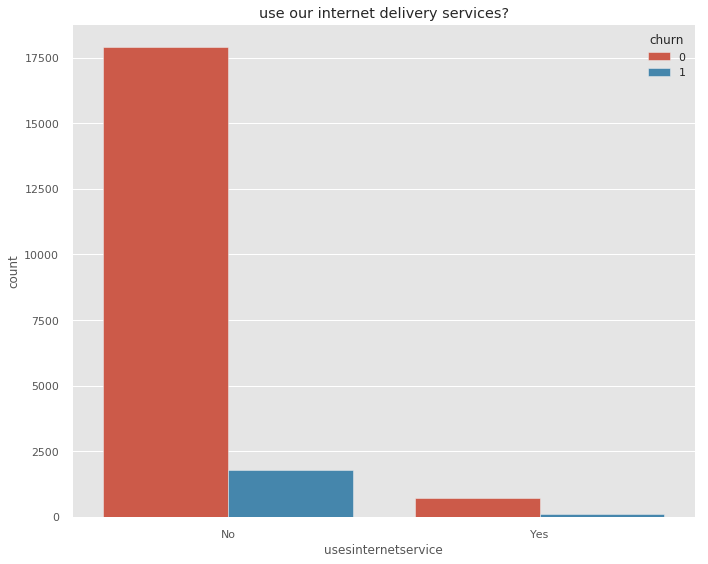

In [6]:
sns.set_color_codes("muted")
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 8))
plt.title('use our internet delivery services?')
sns.countplot(x='usesinternetservice', data=df, hue='churn')
sns.set(style="whitegrid")
plt.tight_layout()

* is a homeowner people more likely to churn ?

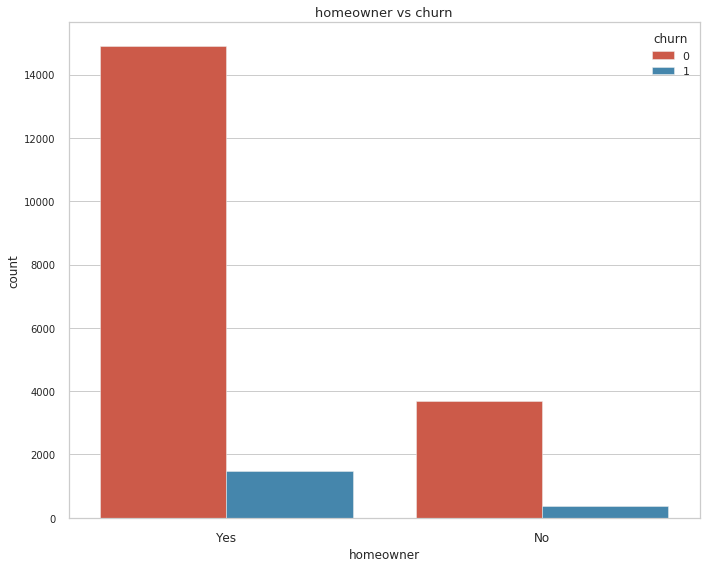

In [7]:
#df.homeowner

fig, ax = plt.subplots(figsize=(10, 8))
plt.style.use('ggplot')
sns.countplot(x='homeowner', hue='churn', data=df, ax=ax)
ax.set_title("{0} vs {1}".format('homeowner', 'churn'), size=13)
plt.setp(ax.get_xticklabels(), rotation=0, size=12)
plt.setp(ax.get_yticklabels(), size=10)
plt.tight_layout()

In [8]:
bin_ranges = [12, 16, 18, 25, 40, 50, 60, 75]
bin_names = ["Teenager", 'Young', 'Young-Adult', 'Adult', 'Adult-II', 'Senior', 'Old']

df['age_bin'] = pd.cut(np.array(df['age']),
                               bins=bin_ranges, labels=bin_names)

* How old are people who buy again?
* Which age groups are we impacting the most?

/opt/conda/lib/python3.6/site-packages/matplotlib/legend.py:497: UserWarning: Unrecognized location "out". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


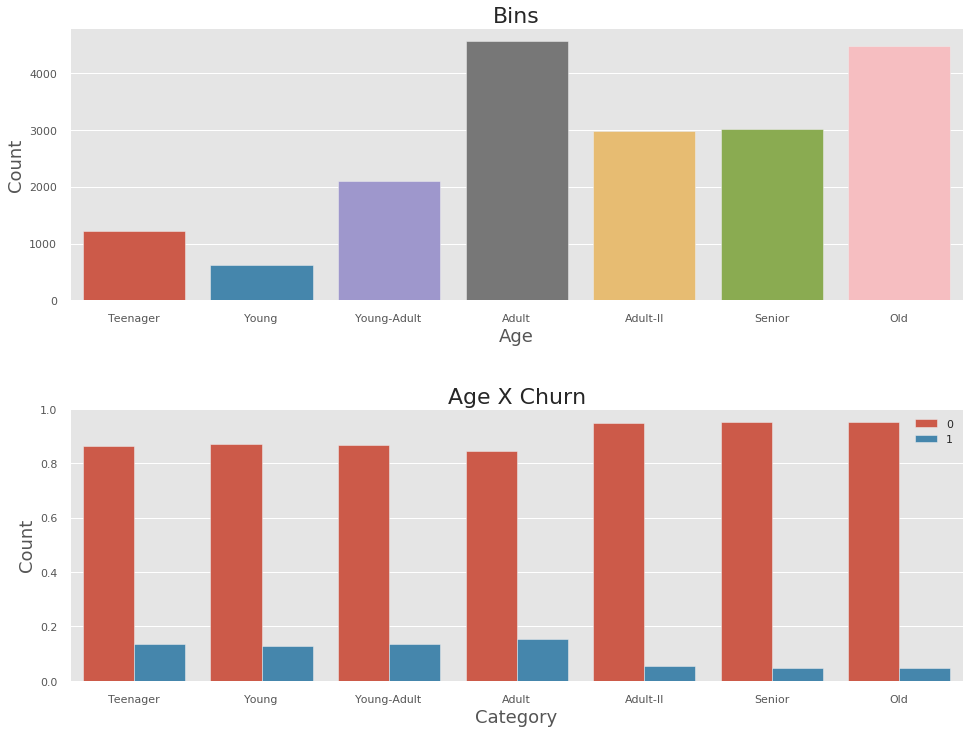

In [9]:

plt.style.use('ggplot')
show_prob_age = pd.crosstab(df['age_bin'], df['churn'], normalize='index')
stacked = show_prob_age.unstack().reset_index().rename(columns={0:'value'});

plt.figure(figsize=(16,12));
plt.subplot(211)
ax1 = sns.countplot(x="age_bin", data=df)
ax1.set_title("Bins", fontsize=22)
ax1.set_xlabel("Age", fontsize=18)
ax1.set_ylabel("Count", fontsize=18)

plt.subplot(212)
ax2 = sns.barplot(x=stacked.age_bin, y=stacked.value, hue=stacked['churn']);
ax2.set_title("Age X Churn", fontsize=22)
ax2.set_xlabel("Category", fontsize=18)
ax2.set_ylabel("Count", fontsize=18)
ax2.legend(loc='out')

plt.subplots_adjust(hspace = 0.4);

plt.show();

Text(0.5, 1.0, 'Education in the database')

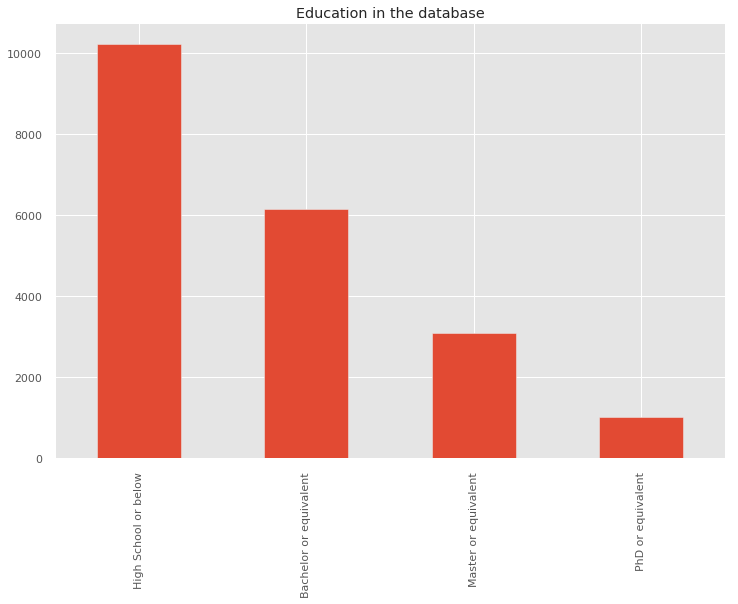

In [10]:
plt.figure(figsize=(12,8))
df.education.value_counts().plot.bar()
plt.title("Education in the database")

In [11]:
binary_features = df[['percentagecalloutsidenetwork', 'callfailurerate', 'avgcallduration']]

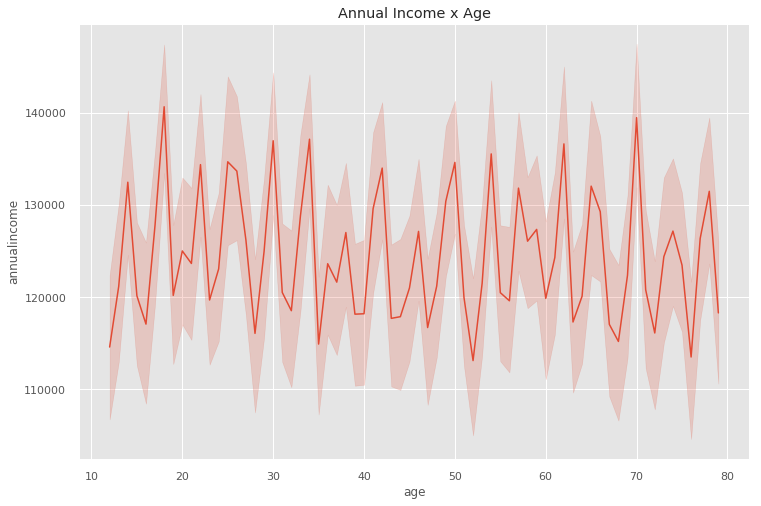

In [12]:
plt.figure(figsize=(12,8))
plt.title("Annual Income x Age")
sns.lineplot(x=df.age, y=df.annualincome)

In [13]:
df.drop('age_bin', axis=1, inplace=True)

In [14]:
df.education.value_counts()

High School or below      10217
Bachelor or equivalent     6138
Master or equivalent       3099
PhD or equivalent          1014
Name: education, dtype: int64

In [16]:
columns_to_encode = list(df.select_dtypes(include=['category','object']))
for column_to_encode in columns_to_encode:
    dummies = pd.get_dummies(df[column_to_encode])
    one_hot_col_names = []
    for col_name in list(dummies.columns):
        one_hot_col_names.append(column_to_encode + '_' + col_name)
    dummies.columns = one_hot_col_names
    df = df.drop(column_to_encode, axis=1)
    df = df.join(dummies)
print('Done')
df.head()

Done


,age,annualincome,calldroprate,callfailurerate,callingnum,customerid,monthlybilledamount,numberofcomplaints,numberofmonthunpaid,numdayscontractequipmentplanexpiring,...,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,usesinternetservice_No,usesinternetservice_Yes,usesvoiceservice_No,usesvoiceservice_Yes
0,12,168147,0.06,0.00,4251078442,1,71,0,7,96,...,0,0,1,0,0,0,1,0,1,0
1,12,168147,0.06,0.00,4251078442,1,71,0,7,96,...,0,0,1,0,0,0,1,0,1,0
2,42,29047,0.05,0.01,4251043419,2,8,1,4,14,...,0,0,0,1,0,0,1,0,0,1
3,42,29047,0.05,0.01,4251043419,2,8,1,4,14,...,0,0,0,1,0,0,1,0,0,1
4,58,27076,0.07,0.02,4251055773,3,16,0,2,55,...,0,0,0,0,0,0,1,0,1,0


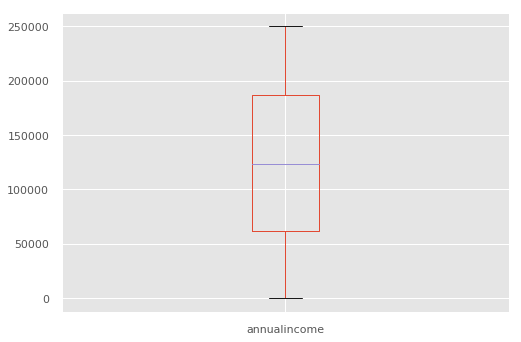

In [17]:
#df.plot.scatter('month','numdayscontractequipmentplanexpiring');
df.annualincome.plot(kind="box");

In [18]:
y = df.churn
x = df.drop('churn', axis=1)

In [19]:

Seed = 420

x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, shuffle = True, 
                                                        random_state = Seed, 
                                                        test_size = 0.2)

In [20]:
print(f"We will train with {x_treino.shape},{y_treino.shape}")
print(f"and test with {x_teste.shape}, {y_teste.shape}")

We will train with (16374, 88),(16374,)
and test with (4094, 88),(4094,)


In [21]:
from sklearn.dummy import DummyClassifier

SEED = 301
np.random.seed = SEED
model = DummyClassifier()
model.fit(x_treino, y_treino)
preds = model.predict(x_teste)
acc = accuracy_score(preds, y_teste)

print('Dummy Score: ', accuracy_score(preds, y_teste)*100)

Dummy Score:  83.56130923302393


In [22]:
from sklearn.dummy import DummyClassifier
model = DummyClassifier(strategy='most_frequent')
model.fit(x_treino, y_treino)
preds = model.predict(x_teste)
acc = accuracy_score(preds, y_teste)

print('the accuracy of the dummy was', accuracy_score(preds, y_teste)*100)

the accuracy of the dummy was 91.64631167562285


In [24]:
model = GaussianNB()
model.fit(x_treino, y_treino)

predicted = model.predict(x_teste)
acc = accuracy_score(predicted, y_teste)
print("the accuracy of the GaussianNb was %.2f%%" %(acc * 100))

the accuracy of the GaussianNb was 90.96%


In [25]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.metrics import accuracy_score

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier, SGDClassifier, LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier, VotingClassifier, RandomTreesEmbedding

LogReg: 0.907110 (+/- 0.007366)
XGBClassifier: 0.907354 (+/- 0.007133)
KNN: 0.902896 (+/- 0.006184)
DecisionTreeClassifier: 0.953768 (+/- 0.007287)
GradientBoostingClassifier: 0.912667 (+/- 0.006968)
RidgeClassifier: 0.907110 (+/- 0.007366)
BaggingRidgeClassifier: 0.953830 (+/- 0.006257)


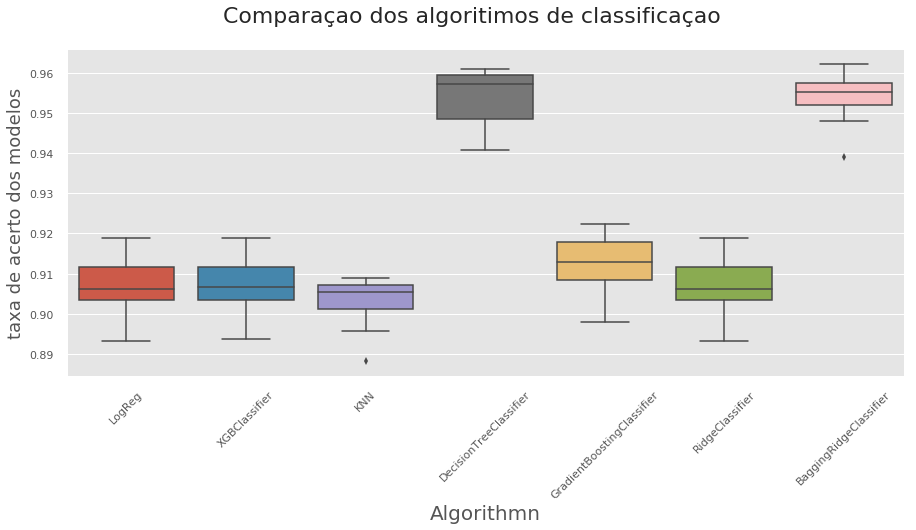

In [26]:
clfs = []
seed = 3

clfs.append(("LogReg", 
             Pipeline([("Scaler", StandardScaler()),
                       ("LogReg", LogisticRegression())])))

clfs.append(("XGBClassifier",
             Pipeline([("Scaler", StandardScaler()),
                       ("XGB", XGBClassifier())]))) 
clfs.append(("KNN", 
             Pipeline([("Scaler", StandardScaler()),
                       ("KNN", KNeighborsClassifier())]))) 

clfs.append(("DecisionTreeClassifier", 
             Pipeline([("Scaler", StandardScaler()),
                       ("DecisionTrees", DecisionTreeClassifier())]))) 

#clfs.append(("RandomForestClassifier", 
#             Pipeline([("Scaler", StandardScaler()),
#                      ("RandomForest", RandomForestClassifier())]))) 

clfs.append(("GradientBoostingClassifier", 
             Pipeline([("Scaler", StandardScaler()),
                       ("GradientBoosting", GradientBoostingClassifier(max_features=15, 
                                                                       n_estimators=600))]))) 

clfs.append(("RidgeClassifier", 
             Pipeline([("Scaler", StandardScaler()),
                       ("RidgeClassifier", RidgeClassifier())])))

clfs.append(("BaggingRidgeClassifier",
             Pipeline([("Scaler", StandardScaler()),
                       ("BaggingClassifier", BaggingClassifier())])))

#clfs.append(("ExtraTreesClassifier",
#            Pipeline([("Scaler", StandardScaler()),
#                      ("ExtraTrees", ExtraTreesClassifier())])))

#'neg_mean_absolute_error', 'neg_mean_squared_error','r2'
scoring = 'accuracy'
n_folds = 10

results, names  = [], [] 

for name, model  in clfs:
    kfold = KFold(n_splits=n_folds, random_state=seed)
    cv_results = cross_val_score(model, x_treino, y_treino, 
                                 cv=kfold, scoring=scoring, n_jobs=-1)    
    names.append(name)
    results.append(cv_results)    
    msg = "%s: %f (+/- %f)" % (name, cv_results.mean(),  
                               cv_results.std())
    print(msg)
    
# boxplot algorithm comparison
fig = plt.figure(figsize=(15,6))
fig.suptitle('Classification algorithms', fontsize=22)
ax = fig.add_subplot(111)
sns.boxplot(x=names, y=results)
ax.set_xticklabels(names)
ax.set_xlabel("Algorithmn", fontsize=20)
ax.set_ylabel("taxa de acerto dos modelos", fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()

In [38]:
model = ExtraTreesClassifier(n_estimators=10)
model.fit(x_treino, y_treino)
preds = model.predict(x_teste)
acc = accuracy_score(preds, y_teste)

print(f"Extra tree classifier {acc * 100}")

predicted = model.predict(x_teste)
predicted_proba = model.predict_proba(x_teste)
#Data Frame
resultados_pred = pd.DataFrame(predicted, columns = ['resultado_pred'])
resultados_proba = pd.DataFrame(predicted_proba, columns = ['0%', '1%'])
resultados_reais = y_teste.to_frame(name='resultado_real')

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Extra tree classifier 98.4123106985833


Confusion matrix:
 [[3752    0]
 [  59  283]]
0.9855886663409869


Text(0, 0.5, 'Expected')

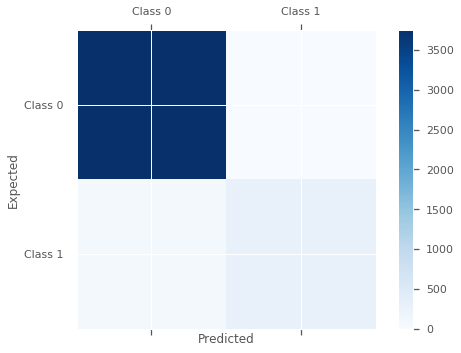

In [28]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_true=y_teste, y_pred=preds)
print('Confusion matrix:\n', conf_mat)
print(accuracy_score(y_teste, preds.round()))

labels = ['Class 0', 'Class 1']
fig = plt.figure();
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')

In [29]:
predicted

array([0, 0, 0, ..., 0, 0, 0])

In [32]:
pred_proba = model.predict_proba(x_teste)

In [33]:
proba = pd.DataFrame(pred_proba, columns=['0%', '1%'])

In [34]:
proba.head()

,0%,1%
0,0.9,0.1
1,0.9,0.1
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
